In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /home/lnnersji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lnnersji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lnnersji/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/lnnersji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
# I'm combining the training and testing data bc the algorithm I used splits it in a way I don't understand lol
df = pd.read_csv("train.tsv", header=None, sep="\t", names=[
    'ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Job', 'State', 'Party',
    'Barely True', 'False', 'Half True', 'Mostly True', 'Pants On Fire', 'Context'])
test_df = df = pd.read_csv("test.tsv", header=None, sep="\t", names=[
    'ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Job', 'State', 'Party',
    'Barely True', 'False', 'Half True', 'Mostly True', 'Pants On Fire', 'Context'])
df = pd.concat([df, test_df])
df = df.dropna()
df.head()

,ID,Label,Statement,Subject,Speaker,Job,State,Party,Barely True,False,Half True,Mostly True,Pants On Fire,Context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
6,7070.json,true,Says that Tennessee law requires that schools ...,"county-budget,county-government,education,taxes",stand-children-tennessee,Child and education advocacy organization.,Tennessee,none,0,0,0,0,0,in a post on Facebook.


In [94]:
feature = []
accuracy = []

In [99]:
# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Statement'],df['Label'],test_size=0.2)
    
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df['Statement'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [100]:
# Naive Bayes Classification Algorithm
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score using Statements -> ",accuracy_score(predictions_NB, Test_Y)*100)

# Add the feature and accuracy to the data list
feature.append("Statement")
accuracy.append(accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score using Statements ->  68.42105263157895


In [101]:
# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Subject'],df['Label'],test_size=0.2)
    
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df['Subject'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [102]:
# Naive Bayes Classification Algorithm
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score using Subjects -> ",accuracy_score(predictions_NB, Test_Y)*100)

# Add the feature and accuracy to the data list
feature.append("Subject")
accuracy.append(accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score using Subjects ->  27.485380116959064


In [103]:
# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Speaker'],df['Label'],test_size=0.2)
    
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df['Speaker'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [104]:
# Naive Bayes Classification Algorithm
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score using Speaker -> ",accuracy_score(predictions_NB, Test_Y)*100)

# Add the feature and accuracy to the data list
feature.append("Speaker")
accuracy.append(accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score using Speaker ->  43.859649122807014


In [105]:
# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Job'],df['Label'],test_size=0.2)
    
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df['Job'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [106]:
# Naive Bayes Classification Algorithm
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score using Job -> ",accuracy_score(predictions_NB, Test_Y)*100)

# Add the feature and accuracy to the data list
feature.append("Job")
accuracy.append(accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score using Job ->  28.07017543859649


In [107]:
# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['State'],df['Label'],test_size=0.2)
    
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df['State'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [108]:
# Naive Bayes Classification Algorithm
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score using State -> ",accuracy_score(predictions_NB, Test_Y)*100)

# Add the feature and accuracy to the data list
feature.append("State")
accuracy.append(accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score using State ->  25.146198830409354


In [109]:
# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Party'],df['Label'],test_size=0.2)
    
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df['Party'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [110]:
# Naive Bayes Classification Algorithm
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score using Party -> ",accuracy_score(predictions_NB, Test_Y)*100)

# Add the feature and accuracy to the data list
feature.append("Party")
accuracy.append(accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score using Party ->  23.099415204678362


In [111]:
# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Context'],df['Label'],test_size=0.2)
    
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df['Context'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [112]:
# Naive Bayes Classification Algorithm
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score using Context -> ",accuracy_score(predictions_NB, Test_Y)*100)

# Add the feature and accuracy to the data list
feature.append("Context")
accuracy.append(accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score using Context ->  37.42690058479532


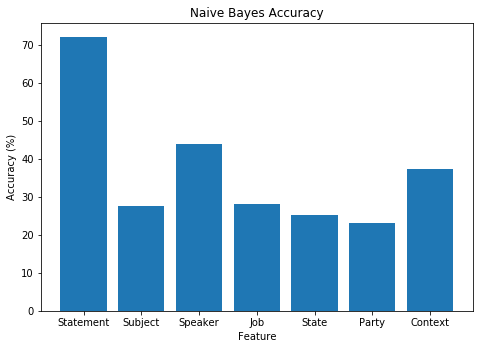

In [116]:
# Plot the accuracy of the algorithm using each feature
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(feature,accuracy)
plt.title("Naive Bayes Accuracy")
plt.ylabel("Accuracy (%)")
plt.xlabel("Feature")
plt.show()

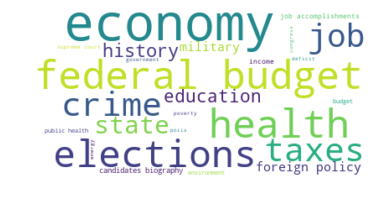

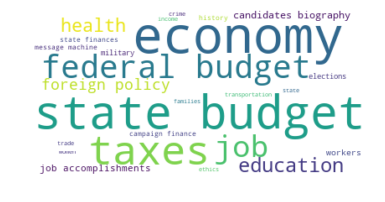

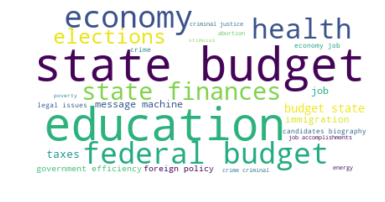

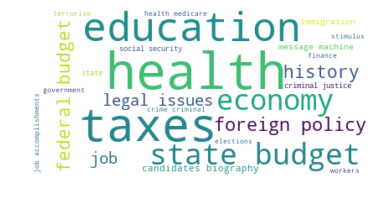

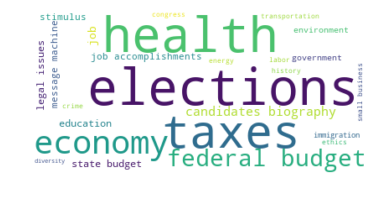

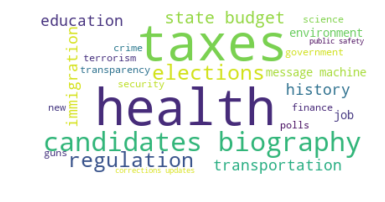

In [116]:
# Generate wordclouds for fake and real news topics
# TRUE wordcloud
is_true = df['Label'] == 'true'
subjects = ' '.join(subjects.replace(',', ' ') for subjects in df[is_true]['Subject'])
wordcloud = WordCloud(stopwords=stopwords.words(), max_font_size=60, max_words=25, background_color='white').generate(subjects)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

is_true = df['Label'] == 'mostly-true'
subjects = ' '.join(subjects.replace(',', ' ') for subjects in df[is_true]['Subject'])
wordcloud = WordCloud(stopwords=stopwords.words(), max_font_size=60, max_words=25, background_color='white').generate(subjects)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

is_true = df['Label'] == 'half-true'
subjects = ' '.join(subjects.replace(',', ' ') for subjects in df[is_true]['Subject'])
wordcloud = WordCloud(stopwords=stopwords.words(), max_font_size=60, max_words=25, background_color='white').generate(subjects)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

is_true = df['Label'] == 'barely-true'
subjects = ' '.join(subjects.replace(',', ' ') for subjects in df[is_true]['Subject'])
wordcloud = WordCloud(stopwords=stopwords.words(), max_font_size=60, max_words=25, background_color='white').generate(subjects)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

is_true = df['Label'] == 'false'
subjects = ' '.join(subjects.replace(',', ' ') for subjects in df[is_true]['Subject'])
wordcloud = WordCloud(stopwords=stopwords.words(), max_font_size=60, max_words=25, background_color='white').generate(subjects)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

is_true = df['Label'] == 'pants-fire'
subjects = ' '.join(subjects.replace(',', ' ') for subjects in df[is_true]['Subject'])
wordcloud = WordCloud(stopwords=stopwords.words(), max_font_size=60, max_words=25, background_color='white').generate(subjects)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()